In [1]:
import Pkg; 

In [2]:
using Pkg, DifferentialEquations, PenaltyFunctions, Optim, StatsBase, Plots, CSV, DataFrames, DiffEqParamEstim;

Co-culture growth

In [3]:
# exponential growth of a single population
#u is the population and p is the parameter
function lv(du,u,p,t)
    du[1] = 0.5330178.*u[1].*(1-(u[1]./417791.1)) - p[1].*u[1].*u[2]
    du[2] = 0.3986739.*u[2].*(1-(u[2]./999999)) + p[1].*u[1].*u[2]
end

u09=[6000; 6000]
tspan=(0.0,10.0)
#p3=[0.000000000000000001]
p3=[0.000000001]

1-element Vector{Float64}:
 1.0e-9

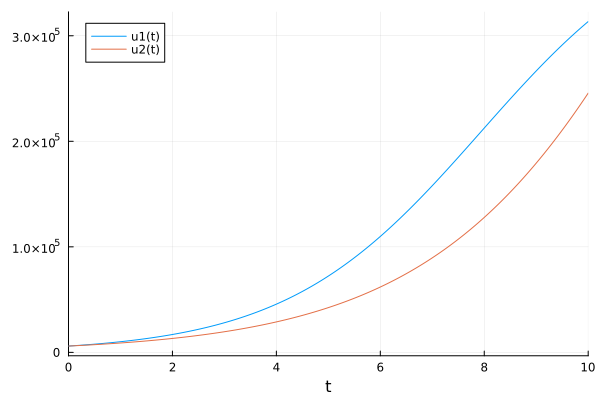

In [4]:
prob = ODEProblem(lv,u09,tspan,p3);
#sol=solve(prob)
sol = solve(prob); #have one time point per day within the 10 days
plot(sol)

In [5]:
function calcAICscore(RSS,n,k)
    AIC = 2.0*(k+1)+n+log(RSS/n)+n*(1+log(2*pi))
end

calcAICscore (generic function with 1 method)

Load data

In [6]:
#import data
t5_5="C:\\Users\\adelpinoherrera\\Dropbox (UFL)\\research-share\\Adriana\\Pt-resistant Ovarian Cancer\\Code\\Pop dynamics T cells\\50-50all.csv"
t=CSV.read(t5_5,DataFrame)
data_t=Matrix(t)

6×11 Matrix{Float64}:
 6000.0  17523.1   28061.9   38050.1  …      1.50848e5       1.42337e5
 6000.0  18924.9   22049.0   51928.3         1.87347e5  176332.0
 6000.0  10914.4   16221.3   43557.3         2.03568e5       1.28519e5
 6000.0   9963.11  10013.2   24482.2     83209.5             1.10145e5
 6000.0  10614.0   11715.4   18724.6     80906.5             1.03636e5
 6000.0   5306.98   6057.97  12216.1  …  54171.3         98129.1

In [7]:
timepts = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0];
repli1_t=data_t[1,:];
repli2_t=data_t[2,:];
repli3_t=data_t[3,:];
repli4_t=data_t[4,:];
repli5_t=data_t[5,:];
repli6_t=data_t[6,:];

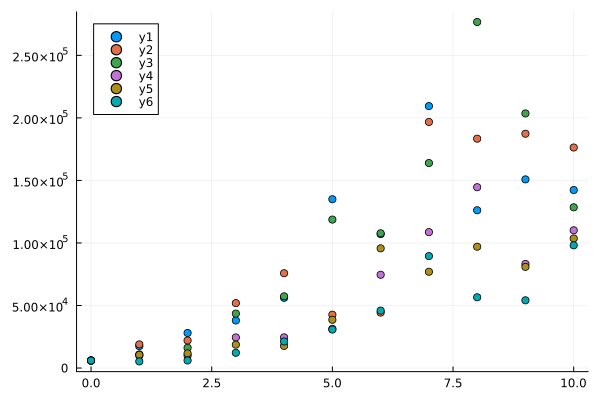

In [8]:
scatter(timepts,repli1_t)
scatter!(timepts,repli2_t)
scatter!(timepts,repli3_t)
scatter!(timepts,repli4_t)
scatter!(timepts, repli5_t)
scatter!(timepts, repli6_t)

# Build loss function

In [9]:
#function to calculate the loss: loss(solve(diffeq), data)
function my_loss_func(sol)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol.u))
      tot_loss = Inf
    else
        # calculation for the loss here
        for i in 1:size(data_t,1)#before size(data)[1] #length(sol.u)
            solI = sol.u[i]
            x = data_t[i,:]
            y = [solI(j)[1] for j in 1:length(x)]
            
            # Debug print statements
            println("Length of x: ", length(x))
            println("Length of y: ", length(y))
            
            # Check and handle dimension mismatch
            if length(x) != length(y)
                error("Dimension mismatch: length of x and y must be the same.")
            end
            
            tot_loss += sum(((x .- y).^2)./((x).^2))
        end
    end
    tot_loss
end 

my_loss_func (generic function with 1 method)

# Building Ensemble Problem for Solving ODE with Differential Initial Conditions

In [10]:
# create initial condition array to pull from
N = size(data_t, 1);
initial_conditions = Vector{Vector{Float64}}(undef,N);

for i = 1:N
    #Separate the initial conditions for each population
   initial_conditions[i] = Float64.(data_t[i,:])
end

In [11]:
# create function that makes that defines the ODE problem with the different initial conditions pulled from data

function prob_func(prob,i,repeat)
  ODEProblem(prob.f,initial_conditions[i],prob.tspan,prob.p);
end

prob_func (generic function with 1 method)

In [12]:
# build & solve the Ensemble problem 
#     number of trajectories are the number of different initial conditions

monte_prob = EnsembleProblem(prob,prob_func=prob_func);
sim = solve(monte_prob, Rodas5(), EnsembleDistributed(), trajectories = size(initial_conditions)[1]); #saveat=1);

# Build Regularized Loss Function

In [13]:
function build_regularized_loss_func(λ)

    function regularized_loss_func(odeparams) 
        
        function prob_func(prob,i,repeat)
            ode_prob=ODEProblem(prob.f,initial_conditions[i],prob.tspan,odeparams);
            return ode_prob
        end
        
        monte_prob = EnsembleProblem(prob,prob_func=prob_func);
        
        sim = solve(monte_prob, 
            Rosenbrock23(autodiff=false),
            EnsembleDistributed(), 
            trajectories = size(initial_conditions)[1]
        );
        
        return my_loss_func(sim) + λ*sum(abs.(odeparams));
    end
    
    return regularized_loss_func;
end

build_regularized_loss_func (generic function with 1 method)

# Run optimization

In [14]:
result = @time Optim.optimize(build_regularized_loss_func(0),
    [0.00000000000001], [0.00000001], ## upper and lower bounds 
    p3, 
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length o

Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length o

Excessive output truncated after 524301 bytes.


Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11
Length of x: 11
Length of y: 11

 * Status: success (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.803362e+02

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 9.00e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.00e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.00e-13 ≰ 1.0e-16

 * Work counters
    Seconds run:   21908  (vs limit Inf)
    Iterations:    1
    f(x) calls:    173412
    ∇f(x) calls:   173412


In [34]:
0.00000000000001

1.0e-14

In [29]:
paramFIT = result.minimizer

1-element Vector{Float64}:
 9.999099785391446e-9

In [30]:
paramFitErr = result.minimum   

180.33620978012118

In [31]:
println("AIC of Exponential Fit: ", calcAICscore(paramFitErr,size(data_t)[1],1))

AIC of Exponential Fit: 30.430325870000736


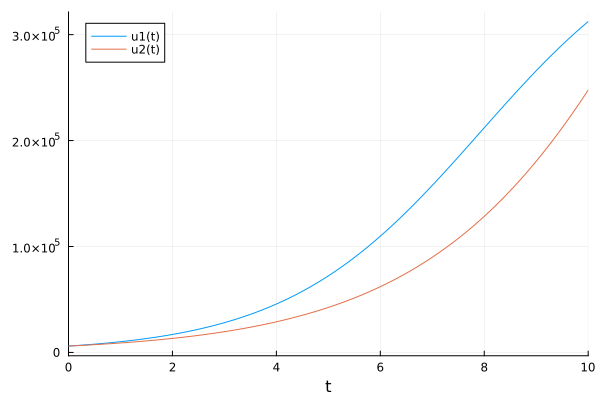

In [32]:
problem = ODEProblem(lv,u09,tspan,paramFIT)
simFit = solve(problem,Vern8());
plot(simFit)

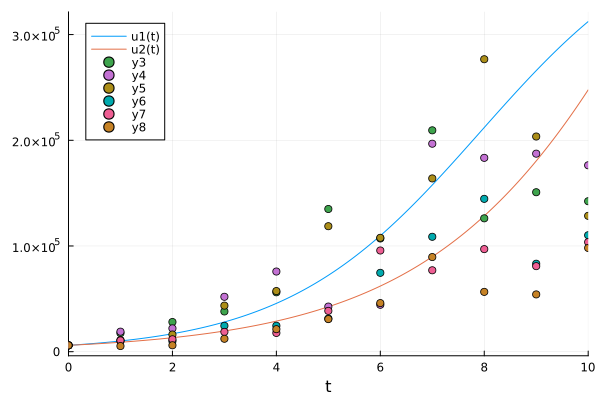

In [33]:
scatter!(timepts,repli1_t)
scatter!(timepts,repli2_t)
scatter!(timepts,repli3_t)
scatter!(timepts,repli4_t)
scatter!(timepts, repli5_t)
scatter!(timepts, repli6_t)